# Regression Analysis

### Imports

In [19]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("deep")
sns.set_context("paper")
sns.set_theme(palette="muted", style='whitegrid', context='paper')

CONSENSUS_TIME = 'consensus_time'
OPINION_CHANGE_FREQUENCY = 'opinion_change_frequency'

FEATURES = [
    'clustering', 'closeness', 'betweenness',
    'average_shortest_path_lenght', 'eigenvector', 'assortativity',
    'information_centrality',
    'approximate_current_flow_betweenness_centrality', 'shannon_entropy',
    'degree_variance'
]

UNCORRELATED_FEATURE_SUBSET = [
    'clustering',
    'closeness',
    'assortativity',
    'shannon_entropy'
]

In [20]:
dataset = pd.read_csv('../data/dataset.csv')

In [21]:
dataset

,network,type,clustering,closeness,betweenness,average_shortest_path_lenght,eigenvector,assortativity,information_centrality,approximate_current_flow_betweenness_centrality,shannon_entropy,degree_variance,initialization,consensus_time,opinion_change_frequency,groups
0,barabasi_linear_60.edgelist,barabasi_linear,0.032393,0.333205,1008.953,3.016906,0.082985,-0.012140,0.003442,0.005008,3.641398,28.577380,random,471.08,248.74,0
1,barabasi_linear_60.edgelist,barabasi_linear,0.032393,0.333205,1008.953,3.016906,0.082985,-0.012140,0.003442,0.005008,3.641398,28.577380,direct,535.92,200.00,0
2,barabasi_linear_60.edgelist,barabasi_linear,0.032393,0.333205,1008.953,3.016906,0.082985,-0.012140,0.003442,0.005008,3.641398,28.577380,inverse,323.41,386.60,0
3,barabasi_linear_91.edgelist,barabasi_linear,0.032772,0.335566,998.585,2.996170,0.081414,-0.026616,0.003427,0.004956,3.629732,31.464265,random,431.67,248.66,0
4,barabasi_linear_91.edgelist,barabasi_linear,0.032772,0.335566,998.585,2.996170,0.081414,-0.026616,0.003427,0.004956,3.629732,31.464265,direct,519.85,200.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,watts-strogatz_76.edgelist,watts-strogatz,0.645758,0.117242,3798.980,8.596960,0.429491,0.008234,0.001636,0.021184,0.596770,3.452053,direct,41172.93,7879.43,4
1670,watts-strogatz_76.edgelist,watts-strogatz,0.645758,0.117242,3798.980,8.596960,0.429491,0.008234,0.001636,0.021184,0.596770,3.452053,inverse,37483.28,6954.85,4
1671,watts-strogatz_69.edgelist,watts-strogatz,0.646363,0.116023,3854.486,8.707972,0.606427,-0.011195,0.001584,0.021171,0.560623,3.452053,random,13790.04,1911.82,4
1672,watts-strogatz_69.edgelist,watts-strogatz,0.646363,0.116023,3854.486,8.707972,0.606427,-0.011195,0.001584,0.021171,0.560623,3.452053,direct,43281.68,7024.76,4


In [51]:
filtered_dataset = dataset.copy()
filtered_dataset = filtered_dataset[filtered_dataset['initialization'] == 'random']
# filtered_dataset.describe()

### Creating Scaler

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# dataset[FEATURES] = scaler.fit_transform(dataset[FEATURES])
# dataset[['consensus_time', 'opinion_change_frequency']] = scaler.fit_transform(dataset[['consensus_time', 'opinion_change_frequency']])

### Adjusted R2

In [53]:
from sklearn.metrics import r2_score

def adjusted_r2_score(y: np.array, y_hat: np.array, n: int, p: int):
    """
    Computes R² score. It decreases if many variables are introduced.
    n: number of observations in sample 
    p: number of independent variables
    """
    return 1 - ((1 - r2_score(y, y_hat)) * ((n - 1)/(n - p - 1)))

### Train Test Split

In [70]:
from sklearn.model_selection import train_test_split

# filtered_dataset.loc[:, FEATURES] = scaler.fit_transform(filtered_dataset[FEATURES])
# filtered_dataset.loc[:, 'opinion_change_frequency'] = scaler.fit_transform(np.array(filtered_dataset['opinion_change_frequency']).reshape(-1, 1))

y = filtered_dataset[CONSENSUS_TIME]
X = sm.add_constant(
   filtered_dataset[FEATURES]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, shuffle=True
)

# X_train[FEATURES] = scaler.fit_transform(X_train[FEATURES])
# X_test[FEATURES] = scaler.transform(X_test[FEATURES])


## Linear

In [71]:
mod = sm.OLS(
    endog=np.log(y_train), 
    exog=sm.add_constant(X_train),
)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.090e+04
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:49:52   Log-Likelihood:                 377.25
No. Observations:                 446   AIC:                            -734.5
Df Residuals:                     436   BIC:                            -693.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

> The smallest eigenvalue is 1.74e-29. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.

This happens because of the strong collinearity between some variables. Lets try to use the UNCORRELATED_FEATURE_SUBSET

In [72]:
mod = sm.OLS(
    endog=np.log(y_train), 
    exog=sm.add_constant(X_train[UNCORRELATED_FEATURE_SUBSET]),
)
res = mod.fit()
print(res.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
No. Observations:                 446   F-statistic:                 1.585e+04
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.5287      0.367     23.222      0.000       7.807       9.251
clustering          3.3245      0.450      7.382      0.000       2.439       4.210
closeness         -11.1279      0.390    -28.506      0.000     -11.895     -10.361
assortativity      -0.4546      0.139     -3.263      0.001      -0.728      -0.181
shannon_entropy     0.3297      0.071      4.625      0.000       0.190       0.470

Notes:
[1] Stand

We still achieve a R-Squared of $0.99$ but without errors related to collinearity

In [73]:
y_pred = res.predict(sm.add_constant(X_test[UNCORRELATED_FEATURE_SUBSET]))

In [74]:
adjusted_r2_score(y_pred, np.log1p(y_test), len(y_pred), len(UNCORRELATED_FEATURE_SUBSET))

0.9937355209993672

### Residuals

<Axes: ylabel='consensus_time'>

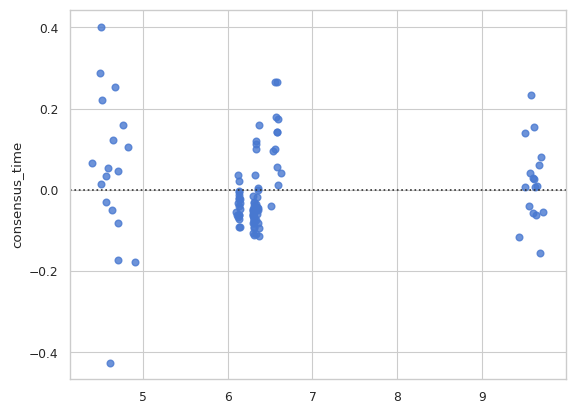

In [75]:
sns.residplot(x=y_pred, y=np.log1p(y_test))

Text(0, 0.5, 'log(Consensus Time)')

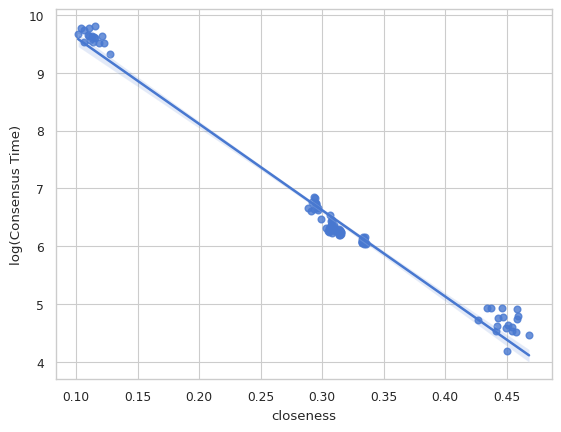

In [76]:
ax = sns.regplot(y=np.log1p(y_test), x=X_test['closeness'])
ax.set_ylabel('log(Consensus Time)')

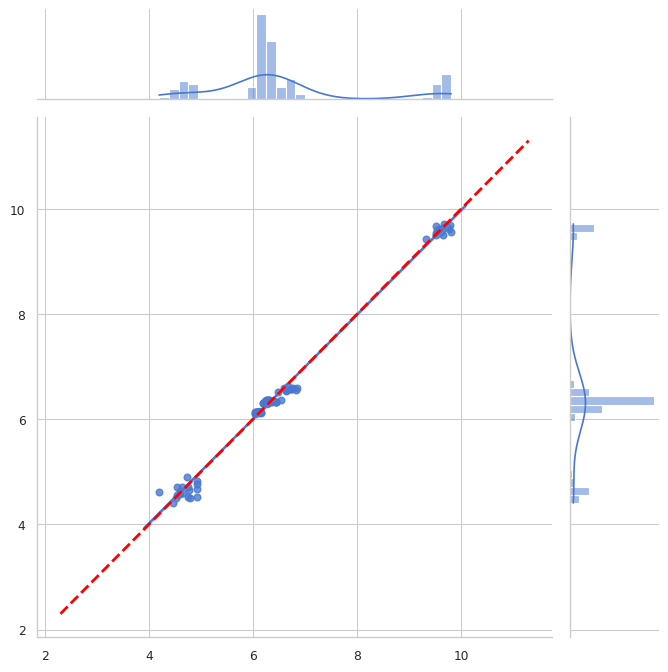

In [77]:
g = sns.jointplot(
    y=y_pred, x=np.log1p(y_test), 
    kind="reg", truncate=False, height=7)
g.set_axis_labels("","")
plt.plot([2.3, 11.3], [2.3, 11.3], '--', lw=2, c='red')


## LASSO Regression
We intend to use Lasso for variable selection

In [32]:
from sklearn.linear_model import LassoCV

X_train[FEATURES] = scaler.fit_transform(X_train[FEATURES])
X_test[FEATURES] = scaler.transform(X_test[FEATURES])

lasso_cv = LassoCV(cv=20, random_state=0).fit(X_train[FEATURES], np.log1p(y_train))

/home/vitor/Documents/SznajdNetworks/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.219e-01, tolerance: 4.847e-01
  model = cd_fast.enet_coordinate_descent(


With fitted alpha, lets see statsmodels summary

In [33]:
mod = sm.OLS(
    endog=np.log1p(y_train), 
    exog=sm.add_constant(X_train[FEATURES]),
)
res = mod.fit_regularized(
    method='elastic_net',
    alpha=lasso_cv.alpha_,
    L1_wt=1,
    refit=True
)

In [34]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     3182.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:40:57   Log-Likelihood:                -751.37
No. Observations:                1339   AIC:                             1521.
Df Residuals:                    1331   BIC:                             1568.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [35]:
y_pred = res.predict(sm.add_constant(X_test[FEATURES]))
adjusted_r2_score(y_pred, np.log1p(y_test), len(y_pred), len(FEATURES))

0.9456021273509851

<Axes: ylabel='consensus_time'>

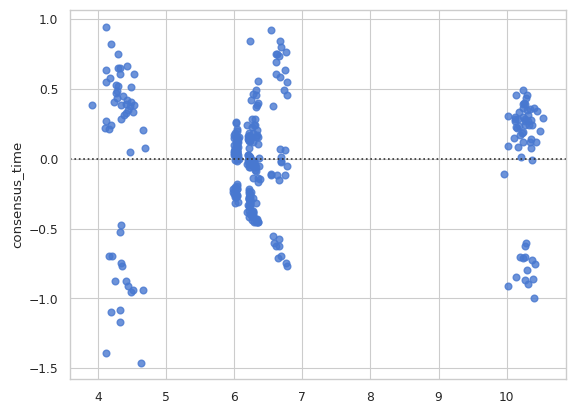

In [36]:
sns.residplot(x=y_pred, y=np.log1p(y_test))